# GridMaster: Multi-Model Grid Search for Credit Card Churn Prediction

<font size = 4>This notebook continues the credit card churn prediction project and serves as a showcase for **GridMaster**, a mature Python package I developed. GridMaster enables multi-model, multi-stage grid search, hyperparameter optimization, and comparative analysis, making it a powerful tool for machine learning workflows.

<font size = 4>We will demonstrate how GridMaster automates the model development process, efficiently compares classifiers, and delivers actionable insights.

## 💡 What is GridMaster?

**GridMaster** is a mature, custom-developed Python package I designed and built to extend and generalize the functionality of standard tools like **GridSearchCV**.

While GridSearchCV from scikit-learn focuses on automated grid search over hyperparameter spaces for a **single model**, **GridMaster** was created to address several practical challenges often encountered in real-world machine learning projects:

- **Multi-model coordination**: Compare and tune multiple classifiers in parallel.
- **Coarse-to-fine hyperparameter tuning**: Search efficiently across wide and narrow parameter ranges.
- **Configurable scoring metrics**: Flexibly prioritize metrics like F1, Accuracy, ROC-AUC, or Recall.
- **Unified result reporting**: Generate comparative tables summarizing best models, parameters, and scores.
- **Visual outputs**: Produce parameter-performance plots and feature importance visualizations for deeper insights.

The package has undergone several rounds of version iteration and visual design improvements, making it a **stable, production-ready tool**.

For new users, GridMaster offers **default settings that enable a fully functional multi-model grid search with as few as three lines of code**, making it easy to get started even without deep customization.

Under the hood, GridMaster implements an **intelligent coarse-to-fine search strategy** that balances broad exploration with fine-grained tuning, achieving efficient and robust optimization across models.

### **📖 [GridMaster User Manual](https://gridmaster.readthedocs.io/en/main/)**
### You can also skip data prep and basline and [Jump Straight to Usage](./03_modeling_with_gridmaster.ipynb#3.3-Model-Development).

## Table of Contents

- [3.1 Data Preparation for Modeling](./03_modeling_with_gridmaster.ipynb#3.1-Data-Preparation-for-Modeling)
- [3.2 Baseline Model](./03_modeling_with_gridmaster.ipynb#3.2-Baseline-Model)
- [3.3 Model Development](./03_modeling_with_gridmaster.ipynb#3.3-Model-Development)
    - [3.3.1 Quickstart for New Users (3 Lines to Get Results)](./03_modeling_with_gridmaster.ipynb#3.3.1-Quickstart-for-New-Users-(3-Lines-to-Get-Results))  
    - [3.3.2 Advanced Class Setup with Expanded Controls](./03_modeling_with_gridmaster.ipynb#3.3.2--Advanced-Class-Setup-with-Expanded-Controls)


In [31]:
from gridmaster import GridMaster

In [2]:
from sklearn import naive_bayes
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel , RFE
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import ComplementNB

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from platform import python_version
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.precision',2)
print(f'Python {python_version()}, Pandas {pd.__version__}, sklearn{sklearn.__version__}')

Python 3.9.7, Pandas 2.2.3, sklearn1.6.1


## 3.1 Data Preparation for Modeling

<font size=3.5>The cleaned and preprocessed dataset used here has been prepared in previous stages of the project, including:

<font size=3.5> - [01_data_cleaning.ipynb](./01_data_cleaning.ipynb): Data ingestion, initial exploration, cleaning, and feature engineering.
    
<font size=3.5> - [02_analysis.ipynb](./02_analysis.ipynb): Exploratory data analysis (EDA), including churn distribution, feature correlations, and key insights.

<font size=3.5>These notebooks provide full details on how the raw credit card churn dataset was transformed into a modeling-ready format; please check on those notebooks as you need.

<font size=3.5>In this notebook, we directly load the cleaned dataset (`X_train`, `y_train`, `X_test`, `y_test`) and proceed with baseline modeling and advanced multi-model optimization using GridMaster.

### Read Train data and Test data from CSV

In [4]:
df_train = pd.read_csv('../data/bank_churners_train.csv', index_col=0)
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]

df_test = pd.read_csv('../data/bank_churners_test.csv', index_col=0)
X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]

### Check Training set to make sure the right dataset was imported

In [5]:
print('X and y shapes:')
print(X_train.shape,y_train.shape,'\n')
print('Target Ratio:')
print(y_train.value_counts(normalize=True, dropna=False),'\n')
df_train.info()

X and y shapes:
(8101, 19) (8101,) 

Target Ratio:
Attrited_Customer
False    0.84
True     0.16
Name: proportion, dtype: float64 

<class 'pandas.core.frame.DataFrame'>
Index: 8101 entries, 6364 to 412
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              8101 non-null   int64  
 1   Gender                    8101 non-null   object 
 2   Dependent_count           8101 non-null   int64  
 3   Education_Level           8101 non-null   object 
 4   Marital_Status            8101 non-null   object 
 5   Income_Category           8101 non-null   object 
 6   Card_Category             8101 non-null   object 
 7   Months_on_book            8101 non-null   int64  
 8   Total_Relationship_Count  8101 non-null   int64  
 9   Months_Inactive_12_mon    8101 non-null   int64  
 10  Contacts_Count_12_mon     8101 non-null   int64  
 11  Credit_Limit              8101 non-null   fl

### Check Testing set 

In [6]:
print('X and y shapes:')
print(X_test.shape,y_test.shape,'\n')
print('Target Ratio:')
print(y_test.value_counts(normalize=True, dropna=False),'\n')
df_test.info()

X and y shapes:
(2026, 19) (2026,) 

Target Ratio:
Attrited_Customer
False    0.84
True     0.16
Name: proportion, dtype: float64 

<class 'pandas.core.frame.DataFrame'>
Index: 2026 entries, 5864 to 9700
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              2026 non-null   int64  
 1   Gender                    2026 non-null   object 
 2   Dependent_count           2026 non-null   int64  
 3   Education_Level           2026 non-null   object 
 4   Marital_Status            2026 non-null   object 
 5   Income_Category           2026 non-null   object 
 6   Card_Category             2026 non-null   object 
 7   Months_on_book            2026 non-null   int64  
 8   Total_Relationship_Count  2026 non-null   int64  
 9   Months_Inactive_12_mon    2026 non-null   int64  
 10  Contacts_Count_12_mon     2026 non-null   int64  
 11  Credit_Limit              2026 non-null   f

**We have imported correct datasets.**
### Then we need to convert categorical features into one-hot coding 

### Apply one-hot encoding (create dummies) to X_train and X_test

In [7]:
X_train = pd.get_dummies(X_train, drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, drop_first=True, dtype=int)

### Then, align the columns between X_train and X_test to ensure identical feature structure

<font size = 3>**Note:**  Categorical features are **one-hot encoded** with `drop_first=True` to **avoid multicollinearity** in logistic regression. Although tree-based models do not require this, we apply the same preprocessing across all models for **consistency**.

In [8]:
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

<font size = 3>**Note:** 
In the previous notebook, we focused on data analysis, so feature encoding (creating dummies) was not performed at that stage. Since this notebook is dedicated to modeling, we are now applying one-hot encoding to the features.

<font size = 3>Typically, the **standard practice** is to **apply pd.get_dummies() before splitting** the dataset into training and testing sets,to ensure consistency between X_train and X_test. 

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8101 entries, 6364 to 412
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Customer_Age                    8101 non-null   int64  
 1   Dependent_count                 8101 non-null   int64  
 2   Months_on_book                  8101 non-null   int64  
 3   Total_Relationship_Count        8101 non-null   int64  
 4   Months_Inactive_12_mon          8101 non-null   int64  
 5   Contacts_Count_12_mon           8101 non-null   int64  
 6   Credit_Limit                    8101 non-null   float64
 7   Total_Revolving_Bal             8101 non-null   int64  
 8   Avg_Open_To_Buy                 8101 non-null   float64
 9   Total_Amt_Chng_Q4_Q1            8101 non-null   float64
 10  Total_Trans_Amt                 8101 non-null   int64  
 11  Total_Trans_Ct                  8101 non-null   int64  
 12  Total_Ct_Chng_Q4_Q1             8101 

## 3.2 Baseline Model

### Build up a logistic model as baseline model

In [10]:
lr = LogisticRegression(solver='liblinear',class_weight = 'balanced')
lr.fit(X_train,y_train)

# print coefficient
print('Coefficient of model :', lr.coef_)
# print intercept of the model
print('\nIntercept of model', lr.intercept_)

Coefficient of model : [[ 3.59326614e-03  1.30445337e-01 -9.88864604e-03 -3.61712808e-01
   5.41931345e-01  5.27812636e-01 -2.68042058e-04 -5.32289918e-04
   2.64253742e-04 -4.48521077e-01  5.20967930e-04 -1.24973833e-01
  -2.48616918e+00 -9.22958646e-02 -6.39761516e-01  2.97156521e-01
  -3.15621875e-02  1.79178879e-02  1.83328163e-01  8.69377186e-02
   1.26066565e-01 -1.46694052e-01  4.18562807e-01  2.81913019e-01
  -3.84742073e-01 -4.99099787e-01 -1.45099067e-01 -1.86191311e-01
  -3.84917764e-01  7.29691984e-01  1.62733709e-01  3.26835507e-01]]

Intercept of model [6.60182899]


### Calculate accuracy on training data

In [11]:
y_pred = lr.predict(X_train)
accuracy_train = accuracy_score(y_train,y_pred)
print('\nAccuracy score on train dataset : ', accuracy_train)


Accuracy score on train dataset :  0.8492778669300086


### Calculate accuracy on testing data

In [12]:
y_pred = lr.predict(X_test)
accuracy_test = accuracy_score(y_test,y_pred)
print('\nAccuracy score on test dataset : ', accuracy_test)


Accuracy score on test dataset :  0.843040473840079


Text(0.5, 1.0, 'Confusion Matrix - Logistic Regression')

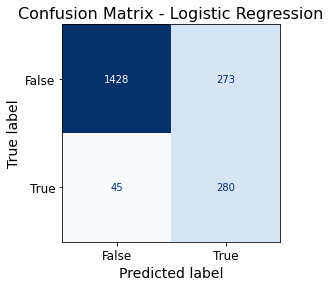

In [13]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, cmap='Blues', colorbar=False )
plt.title('Confusion Matrix - Logistic Regression')

**Observation:**
The baseline logistic regression model achieves reasonably balanced performance, correctly identifying 280 attrited customers while misclassifying 45 of them as existing customers. It also misclassifies 273 existing customers as attrited. The false negative rate (45 out of 325 actual attrited customers) is relatively low, which is important in churn prediction, where failing to identify a churn risk is typically more costly than a false alarm. The confusion matrix suggests that the model is moderately effective in distinguishing churned from non-churned customers, with room for improvement in precision and specificity.

In [14]:
print("Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("Recall (Churn): {:.2%}".format(recall_score(y_test, y_pred)))       
print("Precision (Churn): {:.2%}".format(precision_score(y_test, y_pred)))
print("F1 Score: {:.2%}".format(f1_score(y_test, y_pred)))

Accuracy: 84.30%
Recall (Churn): 86.15%
Precision (Churn): 50.63%
F1 Score: 63.78%


**Model Performance Summary:**

The baseline logistic regression model achieved an accuracy of **84.3%** on the test set. However, given the imbalanced nature of the churn dataset, we rely more heavily on the **recall** and **precision** metrics.

- **Recall (86.2%)**: The model successfully identified a large majority of the actual attrited customers, which is crucial in churn prediction where missing a potential churner could result in customer loss.
- **Precision (50.6%)**: The model's precision is relatively low, indicating that about half of the customers predicted as churners were actually not. This implies a higher rate of false positives, which may be acceptable in some business contexts where it is better to over-alert than to miss a potential churn.
- **F1 Score (63.8%)**: The harmonic mean between precision and recall provides a balanced view of model effectiveness. A score of 63.8% suggests a moderately effective baseline model.

Overall, while the model excels at **catching attrited customers (high recall)**, its **precision needs improvement** to reduce unnecessary interventions. Subsequent models such as decision trees or ensemble methods may help strike a better balance.

## 3.3 Model Development

## 3.3.1 Quickstart for New Users (3 Lines to Get Results)

### Initiate the class with selected models and training data

In [15]:
gm = GridMaster(models=['logistic', 'random_forest', 'xgboost'], X_train=X_train, y_train=y_train)

### Performs an automated coarse-to-fine grid search pipeline across all specified models
In churn prediction, the core business goal is not just to predict accurately overall, but specifically to **capture as many actual churned customers as possible**. Missing a churned customer (false negative) means losing the chance to intervene and retain them, which has direct financial impact. On the other hand, falsely flagging a customer who won’t churn (false positive) may lead to some unnecessary retention effort, but the cost is usually smaller.  
Therefore, I prioritize the `recall` metric, which focuses on **minimizing false negatives**, ensuring that the model identifies the largest possible proportion of churned customers — even if it slightly sacrifices precision.

In [16]:
gm.multi_stage_search(scoring='recall')

🔍 [COARSE SEARCHING] for: logistic
Fitting 5 folds for each of 8 candidates, totalling 40 fits
🔧 [STAGE 1 FINE SEARCHING] for: logistic | Scale: 0.5 | Steps: 5
Fitting 5 folds for each of 5 candidates, totalling 25 fits
🔧 [STAGE 2 FINE SEARCHING] for: logistic | Scale: 0.2 | Steps: 5
Fitting 5 folds for each of 5 candidates, totalling 25 fits
🔍 [COARSE SEARCHING] for: random_forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
🔧 [STAGE 1 FINE SEARCHING] for: random_forest | Scale: 0.5 | Steps: 5
⚠️ Skipping stage1 for random_forest: only one parameter combination detected.
Reason: likely due to narrow coarse grid or constrained keys.
Tip: Adjust auto_scale, auto_steps, or provide a richer custom_fine_params.

🔧 [STAGE 2 FINE SEARCHING] for: random_forest | Scale: 0.2 | Steps: 5
⚠️ Skipping stage2 for random_forest: only one parameter combination detected.
Reason: likely due to narrow coarse grid or constrained keys.
Tip: Adjust auto_scale, auto_steps, or provide a richer

### Check and save the report

In [17]:
report = gm.generate_search_report()


For Logistic model:
Scoring metric used: 'recall'
Stage 1: Coarse grid search:
- clf__C in [0.01, 0.1, 1, 10]
- clf__penalty in ['l1', 'l2']
Total of 8 parameter combinations.
Best parameters: {'clf__C': 10, 'clf__penalty': 'l1'}

Stage 2: Multi-stage fine grid search (Round 1):
- clf__C in [5.0, 7.5, 10.0, 12.5, 15.0]
Total of 5 parameter combinations.
Best parameters: {'clf__C': 5.0}

Stage 3: Multi-stage fine grid search (Round 2):
- clf__C in [4.0, 4.5, 5.0, 5.5, 6.0]
Total of 5 parameter combinations.
Best parameters: {'clf__C': 4.0, 'clf__penalty': 'l1'}

✅ Conclusion: Best model for Logistic with best 'recall' score of 0.5883
    - clf__C: 4.0
    - clf__penalty: l1
------------------------------------------------------------

For Random_forest model:
Scoring metric used: 'recall'
Stage 1: Coarse grid search:
- clf__n_estimators in [100, 200]
- clf__max_depth in [5, 10]
- clf__min_samples_split in [2, 5, 10]
Total of 12 parameter combinations.
Best parameters: {'clf__max_depth'

This result indicates that XGBoost is highly effective at correctly identifying churned customers, making it the most suitable choice for this business objective where minimizing false negatives is critical. While other models may offer advantages in precision or interpretability, XGBoost’s strong recall performance makes it the preferred candidate for deployment in churn prevention strategies.

You can retrieve the best model you like by using this code, for example your decide the best model is XGBoost: 
```python
best_model = gm.results['xgboost']['final'].best_estimator_
```

## 3.3.2  Advanced Class Setup with Expanded Controls

### Initiate the class with selected models and training data

In this step, we initialize the `GridMaster` class as a multi-model hyperparameter tuner, including **Logistic Regression**, **Random Forest**, and **XGBoost**.

For advanced users, we apply several key configurations:

- Use `mode='industrial'` to activate expanded, production-level coarse grids (instead of the default quick grids), enabling exploration of a broader hyperparameter space.
- Set `n_jobs=-1` to leverage all available CPU cores, dramatically speeding up large-scale searches.
- Enable `refit=True` to ensure the best model is retrained on the entire training dataset for reliable final modeling.
- Activate `return_train_score=True` to include training set scores in the results, making it easier to analyze overfitting or underfitting.
- Set `verbose=2` for detailed console output, helping to trace each step of the tuning process.

These settings ensure not only flexibility and scalability but also provide a solid foundation for in-depth tuning and performance optimization.

In [18]:
gm = GridMaster(
    models=['random_forest', 'xgboost', 'catboost'],
    X_train=X_train,
    y_train=y_train,
    mode='industrial',  # 👈 Advanced: use wider industrial grids instead of fast mode
    n_jobs=-1,          # 👈 Advanced: use all CPU cores
    refit=True,         # 👈 Advanced: refit best estimator on full training data
    return_train_score=True,  # 👈 Advanced: keep training set scores in results
    verbose=2  # 👈 Advanced: increase verbosity for detailed logs
)

### Performs an automated coarse-to-fine multi-stage grid search across all specified models
For advanced users, I recommend using multi_stage_search() to fully automate the entire grid search pipeline:
✅ Runs an initial coarse search
✅ Follows with multiple fine-tuning stages
✅ Dynamically refines around the best hyperparameter regions
✅ Minimizes manual intervention and maximizes search efficiency

Compared to manually running coarse_search() + fine_search(), this method reduces code repetition and ensures a smooth multi-level optimization process.

Typical advanced configuration:

In [19]:
gm.multi_stage_search(
    cv=5,
    scoring='f1',   # Target metric can be adjusted (e.g., 'accuracy', 'recall', 'roc_auc')
    stages=[(0.5, 5), (0.2, 5)],  # Two fine-tuning rounds: ±50% grid, then ±20%
    search_mode='smart'  # Advanced modes: 'smart', 'expert', or 'custom'
)

🔍 [COARSE SEARCHING] for: random_forest
Fitting 5 folds for each of 27 candidates, totalling 135 fits
🔧 [STAGE 1 FINE SEARCHING] for: random_forest | Scale: 0.5 | Steps: 5
⚠️ Skipping stage1 for random_forest: only one parameter combination detected.
Reason: likely due to narrow coarse grid or constrained keys.
Tip: Adjust auto_scale, auto_steps, or provide a richer custom_fine_params.

🔧 [STAGE 2 FINE SEARCHING] for: random_forest | Scale: 0.2 | Steps: 5
⚠️ Skipping stage2 for random_forest: only one parameter combination detected.
Reason: likely due to narrow coarse grid or constrained keys.
Tip: Adjust auto_scale, auto_steps, or provide a richer custom_fine_params.

🔍 [COARSE SEARCHING] for: xgboost
Fitting 5 folds for each of 81 candidates, totalling 405 fits
🔧 [STAGE 1 FINE SEARCHING] for: xgboost | Scale: 0.5 | Steps: 5
Fitting 5 folds for each of 5 candidates, totalling 25 fits
🔧 [STAGE 2 FINE SEARCHING] for: xgboost | Scale: 0.2 | Steps: 5
Fitting 5 folds for each of 5 candidat

> 💡 Note: In this quickstart, my goal is to capture as many actual churned customers as possible. While maximizing recall could achieve this, it may also result in bothering some non-churning users. Therefore, here I use the 'f1' scoring metric to build a more balanced classifier that weighs both precision and recall.

> ❗ Warning: Since we are using 'industrial' mode with expanded coarse grids, the search may take significant time to complete. Please plan accordingly and consider using 'fast' mode or reducing the number of models for quicker experimentation.

### Visualize CV Parameter Effects
After completing the search and identifying the best model, it’s crucial to **check how each model's performance changes across the explored parameter space**.

By plotting the cross-validation score curves for all models, you can:

✅ Inspect whether performance shows sharp local fluctuations — which suggests that **a denser grid search** might reveal further improvements.  
✅ Detect whether performance curves are relatively smooth and flat — indicating that **the parameter space is likely saturated**, and additional tuning may not yield significant gains.

To do this, we loop over all models and plot their CV score curves:

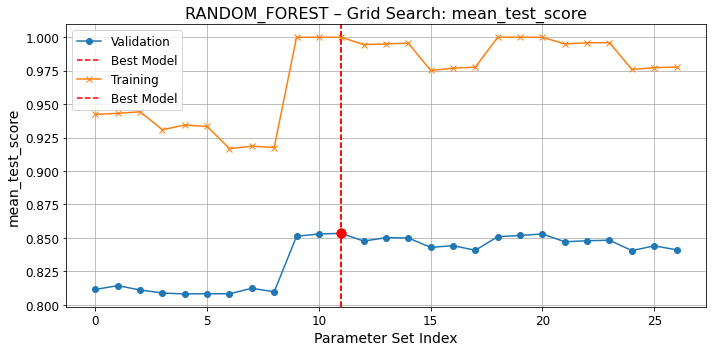

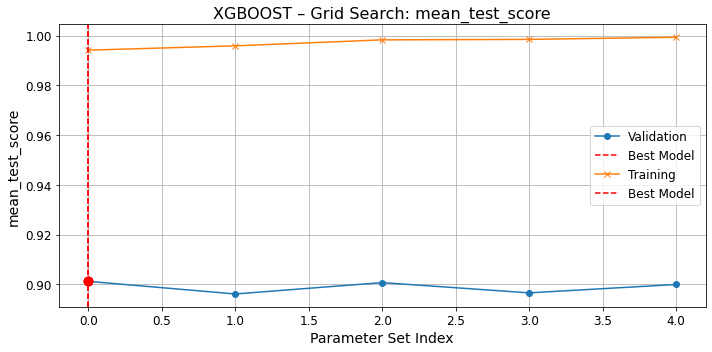

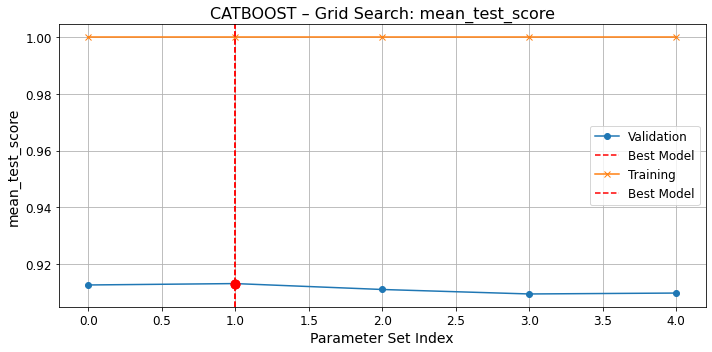

In [20]:
for model in ['random_forest','xgboost','catboost']:
    gm.plot_cv_score_curve(model_name=model)

> By examining the cross-validation parameter effect curves, we observe that the curves are generally smooth, indicating that the hyperparameter space is approaching saturation — in other words, further tuning may yield only marginal improvements.
However, if you identify regions with noticeable local fluctuations or if your use case requires even finer optimization, you can always proceed with an additional targeted fine_search() to explore those parameter zones in more detail.

### Summarize Best Model

Once all parameter searches are complete and the top-performing model has been identified, you can use `gm.get_best_model_summary()` to **quickly retrieve a full summary** of the best model, its optimal parameters, and cross-validation performance.  

This step gives you a **clear overview of which configuration emerged as the overall winner**, helping you decide whether to proceed to test set evaluation or further tuning.

In [21]:
gm.get_best_model_summary()

{'model_name': 'catboost',
 'best_estimator': Pipeline(steps=[('scaler', 'passthrough'),
                 ('clf',
                  <catboost.core.CatBoostClassifier object at 0x15254b700>)]),
 'best_params': {'clf__learning_rate': np.float64(0.07667317),
  'clf__depth': 4,
  'clf__iterations': 500,
  'clf__l2_leaf_reg': 1},
 'cv_best_score': np.float64(0.9131),
 'test_scores': {}}

### Evaluate on Test Set

Once the best model has been identified, you can directly retrieve it using the following code and compute key test set metrics.

#### Check the best estimator given from the summary
From the summary, we know the best model for now is **`'catboost'`**. But you can always identify the model you wanna check:

In [22]:
best_model = gm.results['catboost']['final'].best_estimator_

#### Generate predictions and probability scores and Compute key evaluation metrics

In [23]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # probability for positive class

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.9738
F1 Score: 0.9173
Precision: 0.9304
Recall: 0.9046
ROC AUC: 0.9957


>⚠️ Note:
If you observe that test set performance is significantly lower than cross-validation scores, this may indicate:
	•	Overfitting (cross-validation estimate is overly optimistic)
	•	Feature or distribution drift (train-test gap exists)
    
> In such cases, you should proceed to the next step — advanced diagnostics, error analysis, or retraining with better regularization or updated data

###  Visualize Best Model on Test Set
After selecting the overall best model,
we perform a final diagnostic check on the test set.

These visualizations help assess how well the model generalizes to unseen data and provide insight into its strengths, weaknesses, and trade-offs.
You’ll get plots such as:
- Confusion Matrix → Understand class-level accuracy, false positives, false negatives.
- ROC Curve → See the trade-off between true positive and false positive rates. 
- Precision-Recall Curve → Especially useful for imbalanced datasets, showing the balance between precision and recall.

#### Get the best model name automatically

In [24]:
best_model_name = gm.best_model_name

#### Plot confusion matrix

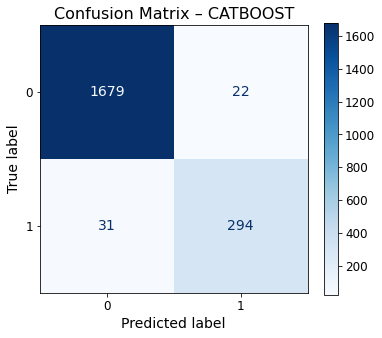

In [25]:
gm.plot_confusion_matrix(model_name=best_model_name, X_test=X_test, y_test=y_test)

#### Plot ROC curve

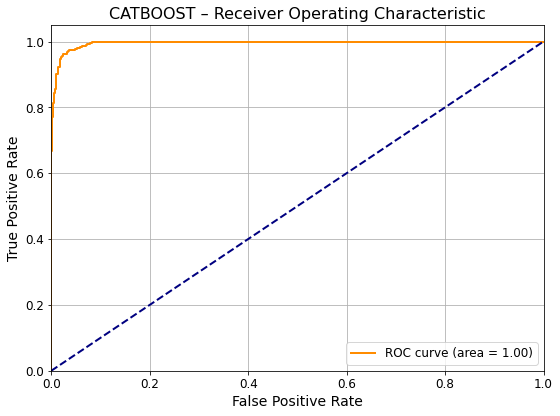

In [26]:
gm.plot_roc_curve(model_name=best_model_name, X_test=X_test, y_test=y_test)

#### Plot Precision-Recall curve

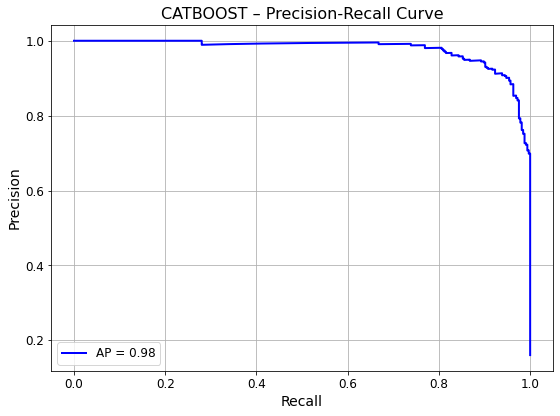

In [27]:
gm.plot_precision_recall_curve(model_name=best_model_name, X_test=X_test, y_test=y_test)

### Summary of Test Set Evaluation Results
- The **confusion matrix** shows excellent classification balance, with a very low number of false positives (22) and false negatives (31), indicating both high precision and high recall.
- The **ROC curve** has an area under the curve (AUC) of nearly 1.00, reflecting near-perfect separability between positive and negative classes — the model confidently distinguishes churned from non-churned customers.
- The **precision-recall (PR) curve** shows an average precision (AP) of 0.98, confirming the model maintains excellent positive class detection even under class imbalance, making it highly reliable for prioritizing true churn cases.

Overall, these results suggest the model generalizes extremely well to the test set, with minimal overfitting or performance drop. You can confidently proceed to deployment or, if desired, run further domain-specific error analysis for fine-tuned improvements.

### Analyze Feature Importance
Understanding which features drive the model’s predictions is critical for interpretability, trust, and actionable insights.

In this step, we analyze the feature importance scores provided by tree-based models (like XGBoost, LightGBM, or Random Forest) or the absolute coefficient magnitudes from linear models (like Logistic Regression).

This helps answer key questions such as:
- Which features most strongly influence churn predictions?
- Are there unexpected or non-intuitive drivers in the data?
- Can we simplify the model by focusing on top-ranked features?

By visualizing and interpreting these importance scores, advanced users can perform deeper diagnostics, guide feature engineering, and communicate results more effectively to stakeholders.

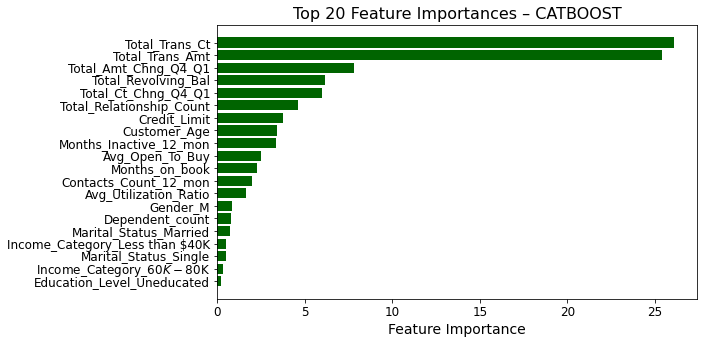

In [28]:
gm.plot_feature_importance(model_name=best_model_name)

From this plot we can tell:

**Top Features Dominate**
The top few features (at the top of the chart) contribute overwhelmingly to the model’s predictive power. These variables are the primary drivers of the churn prediction and should be carefully examined for both interpretation and business action.

**Long Tail of Less Important Features**
There’s a long tail of features with much lower importance. This suggests that many variables have minimal or redundant contributions, and the model’s performance might not degrade much if you simplify it by focusing only on the top-ranked features.

**Opportunities for Feature Engineering**
The top predictors could guide targeted feature engineering, such as creating interaction terms or transformations. Meanwhile, the low-importance variables might be candidates for removal or re-evaluation.


> Note: If your selected model is a Logistic Regression, you can also use `gm.plot_model_coefficients()` to directly visualize the feature coefficients after tuning.

### Compare All Models
This step systematically compares all trained models on the provided test set using multiple evaluation metrics, such as accuracy, F1 score, and ROC AUC.
By ranking models across these metrics (using the default rank_sum strategy), GridMaster identifies which model achieves the best overall balance in performance, allowing you to make an informed selection.

In [29]:
gm.compare_best_models(X_test,y_test)

('catboost',
                accuracy    f1  roc_auc  score
 random_forest      0.96  0.86     0.99    9.0
 xgboost            0.97  0.89     0.99    6.0
 catboost           0.97  0.92     1.00    3.0)

#### Conclusion

Based on the rank-sum evaluation across accuracy, F1 score, and ROC AUC on the test set, CatBoost emerges as the top-performing model with the lowest cumulative rank score (3.0).
This suggests that CatBoost not only delivers the highest ROC AUC (1.00) but also maintains superior balance between precision and recall (as reflected by its leading F1 score of 0.92), making it the most reliable choice among the tested models.

### Understanding the `score` in Model Comparison Function `compare_best_models()`
By ranking models across these metrics (using the default rank_sum strategy), GridMaster identifies which model achieves the best overall balance, helping you make an informed selection.

The `score` column above represents the sum of the rankings across all specified evaluation metrics.
Specifically:
- For each metric (e.g., accuracy, f1, roc_auc), all models are ranked from best to worst.
For example, the best model in accuracy gets rank 1, the second-best gets rank 2, and so on.
- The overall score is calculated as:`score = rank_accuracy + rank_f1 + rank_roc_auc + ...`

A **lower total score** indicates a better overall performance across all metrics, making it easier to identify the most consistently strong model.

In the given output, the model with the lowest score (e.g., catboost with score 3.0) is selected as the top-ranked model.

###  Generate Search Report

In [30]:
report = gm.generate_search_report()


For Random_forest model:
Scoring metric used: 'f1'
Stage 1: Coarse grid search:
- clf__n_estimators in [300, 500, 1000]
- clf__max_depth in [10, 20, None]
- clf__min_samples_split in [2, 5, 10]
Total of 27 parameter combinations.
Best parameters: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 1000}

✅ Conclusion: Best model for Random_forest with best 'f1' score of 0.8534
    - clf__max_depth: 20
    - clf__min_samples_split: 2
    - clf__n_estimators: 1000
------------------------------------------------------------

For Xgboost model:
Scoring metric used: 'f1'
Stage 1: Coarse grid search:
- clf__n_estimators in [300, 500, 1000]
- clf__max_depth in [3, 5, 7]
- clf__learning_rate in [0.01, 0.05, 0.1]
- clf__subsample in [0.6, 0.8, 1.0]
Total of 81 parameter combinations.
Best parameters: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 300, 'clf__subsample': 0.8}

Stage 2: Multi-stage fine grid search (Round 1):
- clf__learning_rate in [0

[CV] END clf__max_depth=10, clf__min_samples_split=2, clf__n_estimators=500; total time=   3.4s
[CV] END clf__max_depth=10, clf__min_samples_split=5, clf__n_estimators=300; total time=   2.1s
[CV] END clf__max_depth=10, clf__min_samples_split=5, clf__n_estimators=500; total time=   3.8s
[CV] END clf__max_depth=10, clf__min_samples_split=5, clf__n_estimators=1000; total time=   7.5s
[CV] END clf__max_depth=20, clf__min_samples_split=2, clf__n_estimators=300; total time=   2.4s
[CV] END clf__max_depth=20, clf__min_samples_split=2, clf__n_estimators=500; total time=   4.1s
[CV] END clf__max_depth=20, clf__min_samples_split=5, clf__n_estimators=300; total time=   2.2s
[CV] END clf__max_depth=20, clf__min_samples_split=5, clf__n_estimators=500; total time=   3.6s
[CV] END clf__max_depth=20, clf__min_samples_split=5, clf__n_estimators=1000; total time=   7.5s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=300; total time=   2.4s
[CV] END clf__max_depth=None, clf__m

[CV] END clf__max_depth=10, clf__min_samples_split=2, clf__n_estimators=300; total time=   2.0s
[CV] END clf__max_depth=10, clf__min_samples_split=2, clf__n_estimators=1000; total time=   7.2s
[CV] END clf__max_depth=10, clf__min_samples_split=5, clf__n_estimators=1000; total time=   7.0s
[CV] END clf__max_depth=20, clf__min_samples_split=2, clf__n_estimators=300; total time=   2.4s
[CV] END clf__max_depth=20, clf__min_samples_split=2, clf__n_estimators=500; total time=   4.0s
[CV] END clf__max_depth=20, clf__min_samples_split=2, clf__n_estimators=1000; total time=   7.8s
[CV] END clf__max_depth=20, clf__min_samples_split=10, clf__n_estimators=300; total time=   2.3s
[CV] END clf__max_depth=20, clf__min_samples_split=10, clf__n_estimators=500; total time=   3.7s
[CV] END clf__max_depth=20, clf__min_samples_split=10, clf__n_estimators=1000; total time=   7.2s
[CV] END clf__max_depth=None, clf__min_samples_split=5, clf__n_estimators=300; total time=   2.5s
[CV] END clf__max_depth=None, c

[CV] END clf__max_depth=10, clf__min_samples_split=2, clf__n_estimators=300; total time=   2.0s
[CV] END clf__max_depth=10, clf__min_samples_split=2, clf__n_estimators=1000; total time=   7.8s
[CV] END clf__max_depth=10, clf__min_samples_split=10, clf__n_estimators=300; total time=   2.3s
[CV] END clf__max_depth=10, clf__min_samples_split=10, clf__n_estimators=500; total time=   3.7s
[CV] END clf__max_depth=10, clf__min_samples_split=10, clf__n_estimators=1000; total time=   7.3s
[CV] END clf__max_depth=20, clf__min_samples_split=2, clf__n_estimators=1000; total time=   7.6s
[CV] END clf__max_depth=20, clf__min_samples_split=10, clf__n_estimators=300; total time=   2.2s
[CV] END clf__max_depth=20, clf__min_samples_split=10, clf__n_estimators=500; total time=   3.7s
[CV] END clf__max_depth=20, clf__min_samples_split=10, clf__n_estimators=1000; total time=   7.2s
[CV] END clf__max_depth=None, clf__min_samples_split=5, clf__n_estimators=300; total time=   2.6s
[CV] END clf__max_depth=None

[CV] END clf__max_depth=10, clf__min_samples_split=2, clf__n_estimators=300; total time=   2.1s
[CV] END clf__max_depth=10, clf__min_samples_split=2, clf__n_estimators=1000; total time=   7.1s
[CV] END clf__max_depth=10, clf__min_samples_split=5, clf__n_estimators=1000; total time=   7.3s
[CV] END clf__max_depth=20, clf__min_samples_split=2, clf__n_estimators=300; total time=   2.7s
[CV] END clf__max_depth=20, clf__min_samples_split=2, clf__n_estimators=500; total time=   4.0s
[CV] END clf__max_depth=20, clf__min_samples_split=5, clf__n_estimators=300; total time=   2.3s
[CV] END clf__max_depth=20, clf__min_samples_split=5, clf__n_estimators=500; total time=   3.8s
[CV] END clf__max_depth=20, clf__min_samples_split=5, clf__n_estimators=1000; total time=   7.7s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=300; total time=   2.2s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=500; total time=   3.9s
[CV] END clf__max_depth=None, clf

[CV] END clf__max_depth=10, clf__min_samples_split=2, clf__n_estimators=500; total time=   3.4s
[CV] END clf__max_depth=10, clf__min_samples_split=5, clf__n_estimators=300; total time=   2.2s
[CV] END clf__max_depth=10, clf__min_samples_split=5, clf__n_estimators=500; total time=   3.7s
[CV] END clf__max_depth=10, clf__min_samples_split=5, clf__n_estimators=1000; total time=   7.2s
[CV] END clf__max_depth=20, clf__min_samples_split=2, clf__n_estimators=300; total time=   2.4s
[CV] END clf__max_depth=20, clf__min_samples_split=2, clf__n_estimators=500; total time=   4.0s
[CV] END clf__max_depth=20, clf__min_samples_split=5, clf__n_estimators=300; total time=   2.2s
[CV] END clf__max_depth=20, clf__min_samples_split=5, clf__n_estimators=500; total time=   3.8s
[CV] END clf__max_depth=20, clf__min_samples_split=5, clf__n_estimators=1000; total time=   7.6s
[CV] END clf__max_depth=None, clf__min_samples_split=2, clf__n_estimators=300; total time=   2.4s
[CV] END clf__max_depth=None, clf__m

[CV] END clf__max_depth=10, clf__min_samples_split=2, clf__n_estimators=500; total time=   3.7s
[CV] END clf__max_depth=10, clf__min_samples_split=5, clf__n_estimators=300; total time=   2.4s
[CV] END clf__max_depth=10, clf__min_samples_split=5, clf__n_estimators=500; total time=   3.9s
[CV] END clf__max_depth=10, clf__min_samples_split=10, clf__n_estimators=300; total time=   2.2s
[CV] END clf__max_depth=10, clf__min_samples_split=10, clf__n_estimators=500; total time=   3.5s
[CV] END clf__max_depth=10, clf__min_samples_split=10, clf__n_estimators=1000; total time=   7.3s
[CV] END clf__max_depth=20, clf__min_samples_split=2, clf__n_estimators=1000; total time=   7.4s
[CV] END clf__max_depth=20, clf__min_samples_split=10, clf__n_estimators=300; total time=   2.2s
[CV] END clf__max_depth=20, clf__min_samples_split=10, clf__n_estimators=500; total time=   3.8s
[CV] END clf__max_depth=20, clf__min_samples_split=10, clf__n_estimators=1000; total time=   7.2s
[CV] END clf__max_depth=None, c